# Poker Agent V11: Statistics-Based Architecture with EV Reward Shaping

**Key Changes from V10:**
1. **No LSTM**: Replace action history with direct poker statistics
2. **Rich Feature Engineering**: Equity, pot odds, SPR, breakeven equity, etc.
3. **EV-Based Reward Shaping**: Distinguishes between:
   - Losing from a mistake (had the statistical edge, should have won)
   - Losing when folding was correct (no penalty, actually good decision quality)

### The Core Insight
Win rate ≠ Profit. We want the agent to:
- Fold marginal hands (even if we might sometimes win)
- Bet big with strong hands (extract maximum value)
- Not chase bad draws

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import random
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List, Dict, Any
from itertools import combinations
import time

from pokerkit import Automation, NoLimitTexasHoldem, Card, StandardHighHand, Deck

# Constants
SEED = 42

# Actions
ENV_FOLD = 0
ENV_CHECK_CALL = 1
ENV_BET_RAISE = 2
NUM_ACTIONS = 3

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
# ============================================
# Poker Math Helpers
# ============================================

def flatten_cards_list(items):
    """Recursively flatten cards from nested structures."""
    out = []
    if isinstance(items, Card): 
        return [items]
    for x in items:
        if isinstance(x, (list, tuple)): 
            out.extend(flatten_cards_list(x))
        else: 
            out.append(x)
    return out

def monte_carlo_equity(hole_cards: List[Card], board_cards: List[Card], iterations=50) -> float:
    """Calculate hand equity via Monte Carlo simulation."""
    if not hole_cards: 
        return 0.5
    
    wins = 0
    hole_cards = flatten_cards_list(hole_cards)
    board_cards = flatten_cards_list(board_cards)
    known_cards = set(hole_cards + board_cards)
    
    for _ in range(iterations):
        deck_cards = [c for c in Deck.STANDARD if c not in known_cards]
        random.shuffle(deck_cards)
        opp_hole = deck_cards[:2]
        needed_board = 5 - len(board_cards)
        sim_board = board_cards + deck_cards[2:2+needed_board]
        
        my_total = hole_cards + sim_board
        opp_total = opp_hole + sim_board
        
        my_hand = max(StandardHighHand(c) for c in combinations(my_total, 5))
        opp_hand = max(StandardHighHand(c) for c in combinations(opp_total, 5))
        
        if my_hand > opp_hand: 
            wins += 1
        elif my_hand == opp_hand: 
            wins += 0.5
    
    return wins / iterations

In [12]:
# ============================================
# Statistics-Based Poker Environment
# ============================================

class StatisticsPokerEnv(gym.Env):
    """
    V11 Environment: Rich poker statistics instead of action history.
    
    State includes:
    - Card encodings (hole + board)
    - Equity (Monte Carlo)
    - Pot odds, call-to-pot ratio
    - Stack-to-pot ratio (SPR)
    - Position indicator
    - Breakeven equity
    - Street indicator
    """
    
    def __init__(self, num_players: int = 2, starting_stack: int = 1000,
                 small_blind: int = 5, big_blind: int = 10):
        super().__init__()
        self.num_players = num_players
        self.starting_stack = starting_stack
        self.small_blind = small_blind
        self.big_blind = big_blind
        
        # State dimensions:
        # - Hole cards: 52*2 = 104
        # - Board cards: 52*5 = 260
        # - Statistics: 12 features
        # - Street: 4 (one-hot)
        # Total: 380
        self.game_state_dim = 52*2 + 52*5 + 12 + 4
        
        self.observation_space = spaces.Box(
            low=-1, high=2, shape=(self.game_state_dim,), dtype=np.float32
        )
        self.action_space = spaces.Discrete(NUM_ACTIONS)
        
        self.state = None
        self.agent_player_index = 0
        
        # Track decision context for reward shaping
        self.decision_context = None
    
    def _card_to_index(self, card: Card) -> int:
        ranks = '23456789TJQKA'
        suits = 'cdhs'
        return ranks.index(card.rank) * 4 + suits.index(card.suit)
    
    def _encode_card(self, card: Optional[Card]) -> np.ndarray:
        encoding = np.zeros(52, dtype=np.float32)
        if card is not None:
            encoding[self._card_to_index(card)] = 1.0
        return encoding
    
    def _get_observation(self) -> np.ndarray:
        """Build state vector with rich poker statistics."""
        state_vector = []
        
        # === Card Encodings ===
        hole = flatten_cards_list(self.state.hole_cards[self.agent_player_index])
        board = flatten_cards_list(self.state.board_cards)
        
        for i in range(2):
            if i < len(hole):
                state_vector.extend(self._encode_card(hole[i]))
            else:
                state_vector.extend(np.zeros(52, dtype=np.float32))
        
        for i in range(5):
            if i < len(board):
                state_vector.extend(self._encode_card(board[i]))
            else:
                state_vector.extend(np.zeros(52, dtype=np.float32))
        
        # === Poker Statistics ===
        total_pot = sum(self.state.bets)
        current_bet = max(self.state.bets)
        my_bet = self.state.bets[self.agent_player_index]
        to_call = current_bet - my_bet
        my_stack = self.state.stacks[self.agent_player_index]
        opp_stack = self.state.stacks[1 - self.agent_player_index]
        
        # 1. Equity (hand strength)
        equity = monte_carlo_equity(hole, board, iterations=40)
        state_vector.append(equity)
        
        # 2. Pot odds: to_call / (pot + to_call)
        pot_odds = to_call / (total_pot + to_call + 1e-6)
        state_vector.append(pot_odds)
        
        # 3. Call-to-pot ratio: to_call / pot
        call_to_pot = to_call / (total_pot + 1e-6)
        state_vector.append(min(call_to_pot, 2.0))
        
        # 4. Stack-to-pot ratio (SPR)
        spr = my_stack / (total_pot + 1e-6)
        state_vector.append(min(spr / 20.0, 1.0))  # Normalize
        
        # 5. Effective stack ratio
        effective_stack = min(my_stack, opp_stack)
        state_vector.append(effective_stack / self.starting_stack)
        
        # 6. My stack ratio
        state_vector.append(my_stack / self.starting_stack)
        
        # 7. Opponent stack ratio
        state_vector.append(opp_stack / self.starting_stack)
        
        # 8. Pot size (normalized)
        state_vector.append(total_pot / (self.starting_stack * 2))
        
        # 9. Breakeven equity (equity needed to call profitably)
        breakeven_equity = to_call / (total_pot + to_call + 1e-6)
        state_vector.append(breakeven_equity)
        
        # 10. Excess equity (equity - breakeven)
        # Positive = good to call, Negative = should fold
        excess_equity = equity - breakeven_equity
        state_vector.append(excess_equity)
        
        # 11. Invested ratio (what % of starting stack already in pot)
        invested = self.starting_stack - my_stack
        state_vector.append(invested / self.starting_stack)
        
        # 12. Facing bet indicator (0 = check opportunity, 1 = facing bet)
        facing_bet = 1.0 if to_call > 0 else 0.0
        state_vector.append(facing_bet)
        
        # === Street Indicator (one-hot) ===
        street = [0.0, 0.0, 0.0, 0.0]
        if len(board) == 0:
            street[0] = 1.0  # Preflop
        elif len(board) == 3:
            street[1] = 1.0  # Flop
        elif len(board) == 4:
            street[2] = 1.0  # Turn
        else:
            street[3] = 1.0  # River
        state_vector.extend(street)
        
        # Store decision context for reward shaping
        self.decision_context = {
            'equity': equity,
            'pot_bb': total_pot / self.big_blind,
            'to_call_bb': to_call / self.big_blind,
            'breakeven_equity': breakeven_equity,
            'excess_equity': excess_equity
        }
        
        return np.array(state_vector, dtype=np.float32)
    
    def _get_legal_actions(self) -> List[int]:
        legal = []
        if self.state.can_fold():
            legal.append(ENV_FOLD)
        if self.state.can_check_or_call():
            legal.append(ENV_CHECK_CALL)
        if self.state.can_complete_bet_or_raise_to():
            legal.append(ENV_BET_RAISE)
        return legal if legal else [ENV_CHECK_CALL]
    
    def _execute_action(self, action: int) -> None:
        if action == ENV_FOLD:
            if self.state.can_fold():
                self.state.fold()
            elif self.state.can_check_or_call():
                self.state.check_or_call()
        elif action == ENV_CHECK_CALL:
            if self.state.can_check_or_call():
                self.state.check_or_call()
            elif self.state.can_fold():
                self.state.fold()
        elif action == ENV_BET_RAISE:
            if self.state.can_complete_bet_or_raise_to():
                min_r = self.state.min_completion_betting_or_raising_to_amount
                max_r = self.state.max_completion_betting_or_raising_to_amount
                # Raise 2x min bet (pot-sized-ish)
                self.state.complete_bet_or_raise_to(min(min_r * 2, max_r))
            elif self.state.can_check_or_call():
                self.state.check_or_call()
    
    def _run_automations(self) -> None:
        while self.state.can_burn_card():
            self.state.burn_card('??')
        while self.state.can_deal_board():
            self.state.deal_board()
        while self.state.can_push_chips():
            self.state.push_chips()
        while self.state.can_pull_chips():
            self.state.pull_chips()
    
    def reset(self, seed=None, options=None) -> Tuple[np.ndarray, Dict]:
        self.state = NoLimitTexasHoldem.create_state(
            automations=(
                Automation.ANTE_POSTING,
                Automation.BET_COLLECTION,
                Automation.BLIND_OR_STRADDLE_POSTING,
                Automation.HOLE_CARDS_SHOWING_OR_MUCKING,
                Automation.HAND_KILLING,
                Automation.CHIPS_PUSHING,
                Automation.CHIPS_PULLING,
            ),
            ante_trimming_status=True,
            raw_antes={-1: 0},
            raw_blinds_or_straddles=(self.small_blind, self.big_blind),
            min_bet=self.big_blind,
            raw_starting_stacks=[self.starting_stack] * self.num_players,
            player_count=self.num_players,
        )
        while self.state.can_deal_hole():
            self.state.deal_hole()
        self._run_automations()
        self.decision_context = None
        return self._get_observation(), {'legal_actions': self._get_legal_actions()}
    
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        self._execute_action(action)
        self._run_automations()
        
        done = self.state.status is False
        reward = 0.0
        if done:
            reward = (self.state.stacks[self.agent_player_index] - self.starting_stack) / self.big_blind
        
        obs = self._get_observation()
        info = {'legal_actions': self._get_legal_actions() if not done else []}
        return obs, reward, done, False, info
    
    def get_final_reward(self) -> float:
        return (self.state.stacks[self.agent_player_index] - self.starting_stack) / self.big_blind
    
    def get_decision_context(self) -> Dict:
        return self.decision_context if self.decision_context else {}

In [13]:
# ============================================
# EV-Based Reward Shaping
# ============================================

def compute_shaped_reward(final_bb_profit: float, decision_contexts: List[Dict], 
                          actions_taken: List[int]) -> float:
    """
    Compute shaped reward that distinguishes between:
    1. Losing from a mistake (had statistical edge but lost)
    2. Losing when folding was correct (good decision, bad luck doesn't matter)
    
    Args:
        final_bb_profit: Actual profit in big blinds
        decision_contexts: List of context dicts from each decision point
        actions_taken: List of actions taken at each decision
    """
    if not decision_contexts:
        return final_bb_profit
    
    # Base reward is actual profit
    reward = final_bb_profit
    
    # EV quality bonus/penalty
    ev_adjustment = 0.0
    
    for ctx, action in zip(decision_contexts, actions_taken):
        if not ctx:
            continue
            
        equity = ctx.get('equity', 0.5)
        pot_bb = ctx.get('pot_bb', 0)
        to_call_bb = ctx.get('to_call_bb', 0)
        excess_equity = ctx.get('excess_equity', 0)
        
        if action == ENV_FOLD:
            # Folding
            if excess_equity < -0.05:  # Equity was significantly below breakeven
                # GOOD fold! Reward for correct decision
                ev_adjustment += 0.5 * abs(excess_equity)  # Small bonus
            elif excess_equity > 0.1:  # Had good equity but folded
                # BAD fold! Penalty for folding winning hand
                ev_adjustment -= 0.5 * excess_equity
                
        elif action == ENV_CHECK_CALL:
            # Calling
            if to_call_bb > 0:  # Actually faced a bet
                if excess_equity > 0.05:  # Had enough equity
                    # Correct call - small bonus
                    ev_adjustment += 0.2 * excess_equity
                elif excess_equity < -0.1:  # Way below breakeven
                    # Bad call! Should have folded
                    ev_adjustment -= 0.5 * abs(excess_equity) * (pot_bb / 10.0 + 1)
                    
        elif action == ENV_BET_RAISE:
            # Betting/Raising
            if equity > 0.6:  # Strong hand
                # Value betting is good
                ev_adjustment += 0.3 * (equity - 0.5)
            elif equity < 0.35:  # Weak hand bluff
                # Risky bluff - small penalty unless it worked
                if final_bb_profit <= 0:
                    ev_adjustment -= 0.3
    
    # Pot-weighted scaling for actual profit
    last_pot = decision_contexts[-1].get('pot_bb', 10) if decision_contexts else 10
    pot_importance = min(last_pot / 15.0, 3.0)  # Scale based on pot size
    
    if final_bb_profit > 0:
        # Won: Slightly reward bigger pots
        profit_component = final_bb_profit * (1 + 0.05 * pot_importance)
    else:
        # Lost: Extra penalty for losing big pots
        profit_component = final_bb_profit * (1 + 0.1 * pot_importance)
    
    return profit_component + ev_adjustment

In [14]:
# ============================================
# Neural Network (No LSTM)
# ============================================

class StatisticsPokerNet(nn.Module):
    """
    Simple feed-forward network.
    The statistics features do the heavy lifting - network just learns to combine them.
    """
    def __init__(self, state_dim: int, action_dim: int = NUM_ACTIONS):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Linear(128, action_dim)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)


class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, transition):
        self.buffer.append(transition)
    
    def sample(self, batch_size):
        return random.sample(self.buffer, min(len(self.buffer), batch_size))
    
    def __len__(self):
        return len(self.buffer)


class StatisticsAgent:
    def __init__(self, state_dim: int, lr=5e-5):
        self.model = StatisticsPokerNet(state_dim).to(device)
        self.target_model = StatisticsPokerNet(state_dim).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = 0.95  # Slightly lower for poker
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.99990  # Will be recalculated based on num_hands
    
    def select_action(self, state: np.ndarray, legal_actions: List[int], 
                      eval_mode: bool = False) -> int:
        if not eval_mode and random.random() < self.epsilon:
            return random.choice(legal_actions)
        
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.model(state_t)
        
        q_numpy = q_values.cpu().numpy().flatten()
        masked_q = np.full(NUM_ACTIONS, -np.inf)
        for a in legal_actions:
            masked_q[a] = q_numpy[a]
        return int(np.argmax(masked_q))
    
    def train(self, buffer: ReplayBuffer, batch_size: int = 128):
        if len(buffer) < batch_size:
            return None
        
        batch = buffer.sample(batch_size)
        
        states = torch.FloatTensor(np.array([t[0] for t in batch])).to(device)
        actions = torch.LongTensor(np.array([t[1] for t in batch])).to(device)
        rewards = torch.FloatTensor(np.array([t[2] for t in batch])).to(device)
        next_states = torch.FloatTensor(np.array([t[3] for t in batch])).to(device)
        dones = torch.FloatTensor(np.array([t[4] for t in batch])).to(device)
        
        # Current Q
        current_q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Double DQN target
        with torch.no_grad():
            next_actions = self.model(next_states).argmax(1).unsqueeze(1)
            target_q_next = self.target_model(next_states).gather(1, next_actions).squeeze(1)
            target = rewards + (1 - dones) * self.gamma * target_q_next
        
        loss = F.mse_loss(current_q, target)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        
        return loss.item()
    
    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

In [15]:
# ============================================
# Opponent Bots (Realistic Pool)
# ============================================

class HeuristicBot:
    def __init__(self, player_idx=1):
        self.player_idx = player_idx
    
    def get_equity(self, state):
        return monte_carlo_equity(
            flatten_cards_list(state.hole_cards[self.player_idx]),
            flatten_cards_list(state.board_cards),
            iterations=40
        )


class ValueBot(HeuristicBot):
    """Only bets/raises with strong hands. Tight-passive."""
    def select_action(self, state, legal_actions):
        equity = self.get_equity(state)
        if equity > 0.75 and ENV_BET_RAISE in legal_actions:
            return ENV_BET_RAISE
        if equity > 0.50 and ENV_CHECK_CALL in legal_actions:
            return ENV_CHECK_CALL
        if ENV_FOLD in legal_actions:
            return ENV_FOLD
        return ENV_CHECK_CALL


class BluffBot(HeuristicBot):
    """Sometimes bluffs with weak hands. Loose-aggressive."""
    def select_action(self, state, legal_actions):
        equity = self.get_equity(state)
        if equity > 0.70 and ENV_BET_RAISE in legal_actions:
            return ENV_BET_RAISE
        if equity < 0.40 and random.random() < 0.35 and ENV_BET_RAISE in legal_actions:
            return ENV_BET_RAISE  # Bluff!
        if equity > 0.45 and ENV_CHECK_CALL in legal_actions:
            return ENV_CHECK_CALL
        if ENV_FOLD in legal_actions:
            return ENV_FOLD
        return ENV_CHECK_CALL


class BalancedBot(HeuristicBot):
    """Uses pot odds correctly. Solid fundamentals."""
    def select_action(self, state, legal_actions):
        equity = self.get_equity(state)
        if equity > 0.80 and ENV_BET_RAISE in legal_actions:
            return ENV_BET_RAISE
        if ENV_CHECK_CALL in legal_actions:
            if equity > 0.60:
                return ENV_CHECK_CALL
            to_call = max(state.bets) - state.bets[self.player_idx]
            pot_odds = to_call / (sum(state.bets) + to_call + 1e-5)
            if equity > pot_odds + 0.05:  # Need 5% edge
                return ENV_CHECK_CALL
        if ENV_FOLD in legal_actions:
            return ENV_FOLD
        return ENV_CHECK_CALL

In [16]:
# ============================================
# Training Loop with Detailed Logging
# ============================================

def train_v11(num_hands=50000):
    env = StatisticsPokerEnv()
    agent = StatisticsAgent(env.game_state_dim)
    buffer = ReplayBuffer(capacity=100000)
    
    # Opponent pool
    opps = {
        'ValueBot': ValueBot(),
        'BluffBot': BluffBot(),
        'Balanced': BalancedBot()
    }
    opp_names = list(opps.keys())
    
    # Statistics tracking
    stats = {name: {'rewards': [], 'shaped_rewards': [], 'wins': 0, 'hands': 0} 
             for name in opp_names}
    all_rewards = []
    all_shaped = []
    loss_history = []
    action_counts = {0: 0, 1: 0, 2: 0}  # Track action distribution
    
    # Timing
    start_time = time.time()
    
    print("=" * 70)
    print(f"TRAINING V11 (Statistics-Based Agent)")
    print("=" * 70)
    print(f"Total hands: {num_hands:,}")
    print(f"State dimension: {env.game_state_dim}")
    print(f"Opponent pool: {', '.join(opp_names)}")
    print()
    
    # Dynamic epsilon decay - calculated based on num_hands
    # Goal: Reach epsilon_min (0.05) at 80% of total training
    decay_steps = int(num_hands * 0.8)
    agent.epsilon_decay = (agent.epsilon_min / agent.epsilon) ** (1 / decay_steps)
    print(f"Epsilon schedule:")
    print(f"  Start: {agent.epsilon:.2f}")
    print(f"  Target: {agent.epsilon_min:.2f} at hand {decay_steps:,} (80% of training)")
    print(f"  Decay factor: {agent.epsilon_decay:.6f}")
    print("=" * 70)
    print()
    
    # Logging intervals - scale with num_hands
    LOG_INTERVAL = max(1000, num_hands // 50)  # Log ~50 times during training
    CHECKPOINT_INTERVAL = max(2500, num_hands // 20)  # Checkpoint ~20 times
    
    for hand in range(num_hands):
        # Switch opponent every 50 hands
        if hand % 50 == 0:
            current_opp_name = random.choice(opp_names)
        opponent = opps[current_opp_name]
        
        obs, info = env.reset()
        done = False
        episode_transitions = []
        decision_contexts = []
        actions_taken = []
        
        pending_obs = None
        pending_action = None
        pending_context = None
        
        while not done:
            if env.state.actor_index == env.agent_player_index:
                # Store previous transition if exists
                if pending_obs is not None:
                    episode_transitions.append((
                        pending_obs, pending_action, 0.0, obs, False
                    ))
                    if pending_context:
                        decision_contexts.append(pending_context)
                        actions_taken.append(pending_action)
                
                # Agent's turn
                action = agent.select_action(obs, info['legal_actions'])
                action_counts[action] += 1
                pending_obs = obs
                pending_action = action
                pending_context = env.get_decision_context().copy() if env.get_decision_context() else None
                
                obs, reward, done, _, info = env.step(action)
                
            else:
                # Opponent's turn
                action = opponent.select_action(env.state, info['legal_actions'])
                env._execute_action(action)
                env._run_automations()
                done = env.state.status is False
                if not done:
                    obs = env._get_observation()
                    info['legal_actions'] = env._get_legal_actions()
        
        # Terminal transition
        final_reward_bb = env.get_final_reward()
        term_obs = env._get_observation()
        
        if pending_obs is not None:
            episode_transitions.append((
                pending_obs, pending_action, 0.0, term_obs, True
            ))
            if pending_context:
                decision_contexts.append(pending_context)
                actions_taken.append(pending_action)
        
        # Compute shaped reward
        shaped_reward = compute_shaped_reward(final_reward_bb, decision_contexts, actions_taken)
        
        # Store transitions with shaped reward
        for i, (s, a, _, ns, d) in enumerate(episode_transitions):
            buffer.push((s, a, shaped_reward, ns, d))
        
        # Track stats
        stats[current_opp_name]['rewards'].append(final_reward_bb)
        stats[current_opp_name]['shaped_rewards'].append(shaped_reward)
        stats[current_opp_name]['hands'] += 1
        if final_reward_bb > 0:
            stats[current_opp_name]['wins'] += 1
        
        all_rewards.append(final_reward_bb)
        all_shaped.append(shaped_reward)
        
        # Training
        if len(buffer) > 2000:
            loss = agent.train(buffer)
            if loss is not None:
                loss_history.append(loss)
        
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        
        if hand % 1000 == 0:
            agent.update_target()
        
        # === LOGGING ===
        if hand > 0 and hand % LOG_INTERVAL == 0:
            elapsed = time.time() - start_time
            hands_per_sec = hand / elapsed if elapsed > 0 else 0
            eta_seconds = (num_hands - hand) / hands_per_sec if hands_per_sec > 0 else 0
            eta_min = eta_seconds / 60
            
            # Calculate recent stats
            recent_reward = np.mean(all_rewards[-LOG_INTERVAL:]) if len(all_rewards) >= LOG_INTERVAL else np.mean(all_rewards)
            recent_shaped = np.mean(all_shaped[-LOG_INTERVAL:]) if len(all_shaped) >= LOG_INTERVAL else np.mean(all_shaped)
            recent_loss = np.mean(loss_history[-100:]) if loss_history else 0
            
            # Action distribution
            total_actions = sum(action_counts.values())
            fold_pct = action_counts[0] / total_actions * 100 if total_actions > 0 else 0
            call_pct = action_counts[1] / total_actions * 100 if total_actions > 0 else 0
            raise_pct = action_counts[2] / total_actions * 100 if total_actions > 0 else 0
            
            progress = hand / num_hands * 100
            print(f"Hand {hand:,}/{num_hands:,} ({progress:.1f}%) | "
                  f"Eps={agent.epsilon:.3f} | "
                  f"Avg BB: {recent_reward:+.2f} | "
                  f"Shaped: {recent_shaped:+.2f} | "
                  f"Loss: {recent_loss:.4f} | "
                  f"Speed: {hands_per_sec:.1f} h/s | "
                  f"ETA: {eta_min:.1f}m")
            print(f"        Actions: Fold {fold_pct:.1f}% | Call {call_pct:.1f}% | Raise {raise_pct:.1f}% | "
                  f"Buffer: {len(buffer):,}")
        
        # === DETAILED CHECKPOINT ===
        if hand > 0 and hand % CHECKPOINT_INTERVAL == 0:
            print()
            print(f"{'='*70}")
            print(f"CHECKPOINT: Hand {hand:,} / {num_hands:,} ({hand/num_hands*100:.1f}%)")
            print(f"{'='*70}")
            
            # Overall stats
            cumulative_bb = sum(all_rewards)
            cumulative_shaped = sum(all_shaped)
            total_wins = sum(s['wins'] for s in stats.values())
            total_hands_played = sum(s['hands'] for s in stats.values())
            win_rate = total_wins / total_hands_played if total_hands_played > 0 else 0
            
            print(f"Cumulative: {cumulative_bb:+.1f} BB (raw) | {cumulative_shaped:+.1f} (shaped)")
            print(f"Overall Win Rate: {win_rate:.1%}")
            print()
            
            # Per-opponent breakdown
            print("Per-Opponent Performance (recent 500 hands):")
            for name in opp_names:
                if stats[name]['hands'] > 0:
                    recent = stats[name]['rewards'][-500:]
                    recent_shaped_opp = stats[name]['shaped_rewards'][-500:]
                    opp_win_rate = stats[name]['wins'] / stats[name]['hands']
                    print(f"  {name:12s}: Avg {np.mean(recent):+.2f} BB | "
                          f"Shaped {np.mean(recent_shaped_opp):+.2f} | "
                          f"Win {opp_win_rate:.1%} | "
                          f"Hands: {stats[name]['hands']:,}")
            print()
    
    # Training complete summary
    total_time = time.time() - start_time
    print()
    print("=" * 70)
    print("TRAINING COMPLETE")
    print("=" * 70)
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    print(f"Total transitions in buffer: {len(buffer):,}")
    print(f"Cumulative reward: {sum(all_rewards):+.1f} BB")
    
    return agent, stats, all_rewards, all_shaped


def evaluate_v11(agent):
    print()
    print("=" * 70)
    print("FINAL V11 EVALUATION (Epsilon=0.0)")
    print("=" * 70)
    
    agent.epsilon = 0.0
    agent.model.eval()
    env = StatisticsPokerEnv()
    opps = {'ValueBot': ValueBot(), 'BluffBot': BluffBot(), 'Balanced': BalancedBot()}
    
    results = {}
    for name, opponent in opps.items():
        print(f"\nEvaluating vs {name}...", end=" ", flush=True)
        rewards, wins = [], 0
        
        for i in range(2000):
            obs, info = env.reset()
            done = False
            
            while not done:
                if env.state.actor_index == env.agent_player_index:
                    action = agent.select_action(obs, info['legal_actions'], eval_mode=True)
                    obs, _, done, _, info = env.step(action)
                else:
                    action = opponent.select_action(env.state, info['legal_actions'])
                    env._execute_action(action)
                    env._run_automations()
                    done = env.state.status is False
                    if not done:
                        obs = env._get_observation()
                        info['legal_actions'] = env._get_legal_actions()
            
            final_reward = env.get_final_reward()
            rewards.append(final_reward)
            if final_reward > 0:
                wins += 1
        
        avg_bb = np.mean(rewards)
        total_bb = sum(rewards)
        win_rate = wins / 2000
        std_bb = np.std(rewards)
        
        results[name] = {'avg_bb': avg_bb, 'total_bb': total_bb, 'win_rate': win_rate, 'std': std_bb}
        status = 'PROFIT' if avg_bb > 0 else 'LOSS'
        print(f"{status}")
        print(f"  Avg: {avg_bb:+.2f} BB (+/-{std_bb:.2f}) | Total: {total_bb:+.1f} BB | Win: {win_rate:.1%}")
    
    # Overall
    print()
    print("-" * 70)
    overall_avg = np.mean([r['avg_bb'] for r in results.values()])
    overall_total = sum(r['total_bb'] for r in results.values())
    print(f"OVERALL: Avg {overall_avg:+.2f} BB | Total: {overall_total:+.1f} BB")
    if overall_avg > 0:
        print("SUCCESS! Agent is profitable!")
    else:
        print("Still negative - may need more training or tuning")
    print("=" * 70)
    
    return results

In [17]:
# ============================================
# RUN TRAINING
# ============================================
# Adjust num_hands as needed - epsilon decay will scale automatically

agent, stats, raw_rewards, shaped_rewards = train_v11(num_hands=50000)
results = evaluate_v11(agent)

TRAINING V11 (Statistics-Based Agent)
Total hands: 50,000
State dimension: 380
Opponent pool: ValueBot, BluffBot, Balanced

Epsilon schedule:
  Start: 1.00
  Target: 0.05 at hand 40,000 (80% of training)
  Decay factor: 0.999925

Hand 1,000/50,000 (2.0%) | Eps=0.928 | Avg BB: -2.60 | Shaped: -3.44 | Loss: 954.3921 | Speed: 11.4 h/s | ETA: 71.5m
        Actions: Fold 5.6% | Call 48.7% | Raise 45.7% | Buffer: 2,552
Hand 2,000/50,000 (4.0%) | Eps=0.861 | Avg BB: -3.41 | Shaped: -4.26 | Loss: 671.4283 | Speed: 11.7 h/s | ETA: 68.3m
        Actions: Fold 6.7% | Call 47.7% | Raise 45.6% | Buffer: 4,822

CHECKPOINT: Hand 2,500 / 50,000 (5.0%)
Cumulative: -6850.0 BB (raw) | -8797.5 (shaped)
Overall Win Rate: 72.5%

Per-Opponent Performance (recent 500 hands):
  ValueBot    : Avg -1.22 BB | Shaped -1.67 | Win 84.0% | Hands: 600
  BluffBot    : Avg -3.61 BB | Shaped -4.50 | Win 66.0% | Hands: 900
  Balanced    : Avg -2.82 BB | Shaped -3.48 | Win 71.3% | Hands: 1,001

Hand 3,000/50,000 (6.0%) | E

In [19]:
torch.save({
    'model_state_dict': agent.model.state_dict(),
    'target_model_state_dict': agent.target_model.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'epsilon': agent.epsilon,
    'total_hands': len(raw_rewards),
}, 'poker_agent_v11.pth')

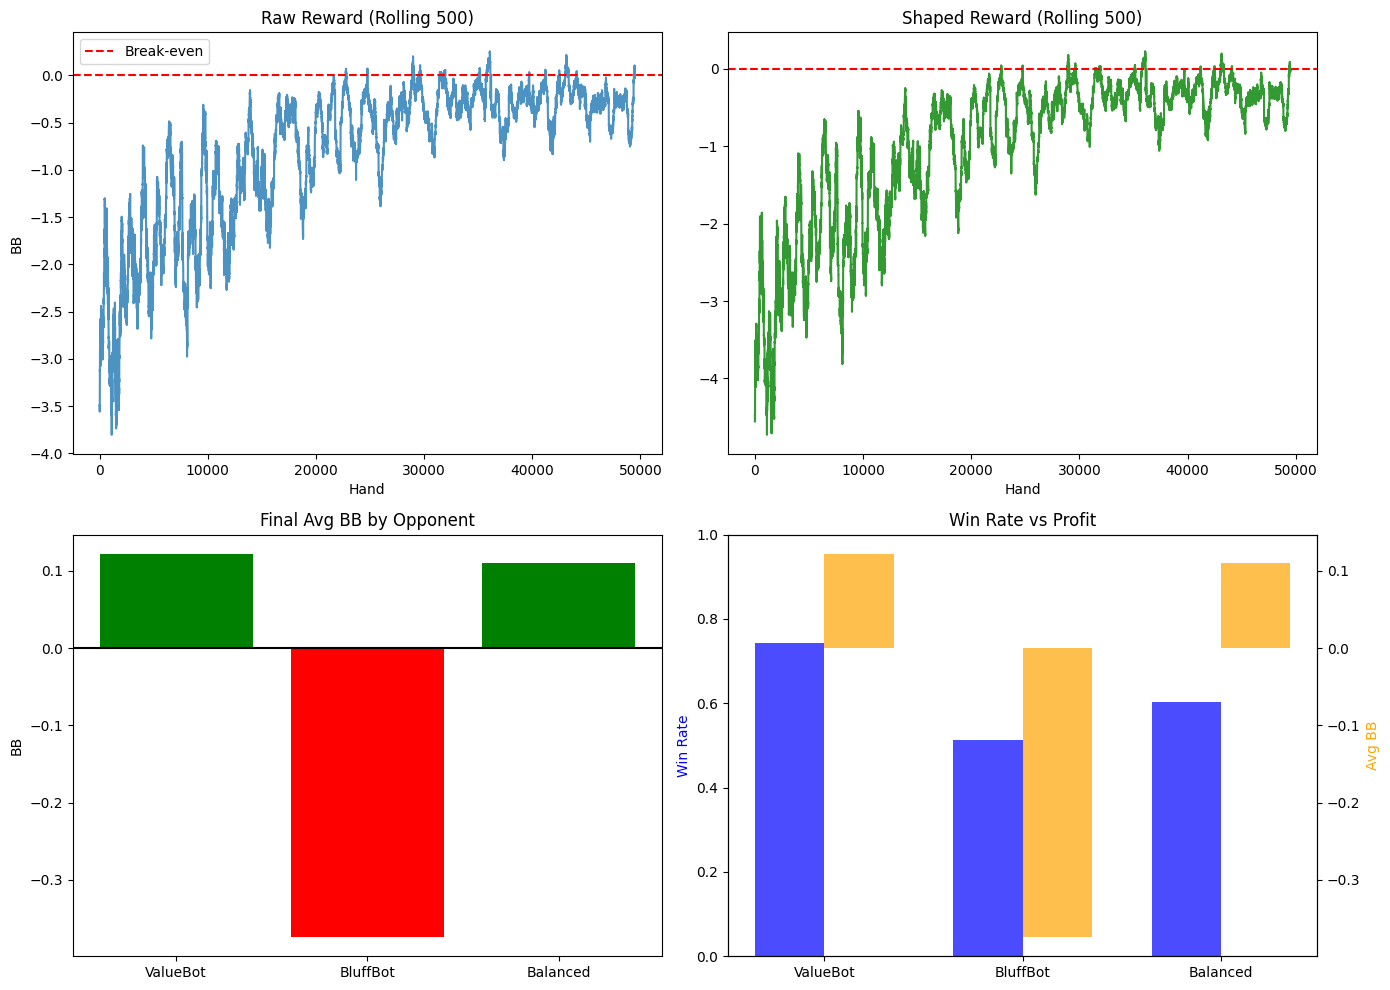


Plot saved to v11_results.png


In [20]:
# ============================================
# Visualize Results
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Rolling average rewards
window = 500
if len(raw_rewards) > window:
    rolling = np.convolve(raw_rewards, np.ones(window)/window, mode='valid')
    axes[0, 0].plot(rolling, alpha=0.8)
axes[0, 0].axhline(y=0, color='r', linestyle='--', label='Break-even')
axes[0, 0].set_title(f'Raw Reward (Rolling {window})')
axes[0, 0].set_xlabel('Hand')
axes[0, 0].set_ylabel('BB')
axes[0, 0].legend()

# Shaped rewards
if len(shaped_rewards) > window:
    rolling_shaped = np.convolve(shaped_rewards, np.ones(window)/window, mode='valid')
    axes[0, 1].plot(rolling_shaped, alpha=0.8, color='green')
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_title(f'Shaped Reward (Rolling {window})')
axes[0, 1].set_xlabel('Hand')

# Per-opponent results
opp_names = list(results.keys())
avg_bbs = [results[n]['avg_bb'] for n in opp_names]
colors = ['green' if x > 0 else 'red' for x in avg_bbs]
axes[1, 0].bar(opp_names, avg_bbs, color=colors)
axes[1, 0].axhline(y=0, color='black', linestyle='-')
axes[1, 0].set_title('Final Avg BB by Opponent')
axes[1, 0].set_ylabel('BB')

# Win rate vs profit comparison
win_rates = [results[n]['win_rate'] for n in opp_names]
x = np.arange(len(opp_names))
width = 0.35
ax2 = axes[1, 1]
ax2.bar(x - width/2, win_rates, width, label='Win Rate', color='blue', alpha=0.7)
ax2.set_ylabel('Win Rate', color='blue')
ax2.set_ylim(0, 1)
ax3 = ax2.twinx()
ax3.bar(x + width/2, avg_bbs, width, label='Avg BB', color='orange', alpha=0.7)
ax3.set_ylabel('Avg BB', color='orange')
ax2.set_xticks(x)
ax2.set_xticklabels(opp_names)
ax2.set_title('Win Rate vs Profit')

plt.tight_layout()
plt.savefig('v11_results.png', dpi=150)
plt.show()
print("\nPlot saved to v11_results.png")